In [1]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB

from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pandas.api.types import is_integer_dtype

from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.naive_bayes import GaussianNB


%matplotlib inline

In [41]:
# Graph params

sns.set()

sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

pd.options.mode.chained_assignment = None 

In [72]:
# Read data

df = pd.read_csv('/content/data/contest_train_binary.csv',  sep=',')
df_test = pd.read_csv('/content/data/contest_test.csv',  sep=',')
df.head()

,ID,TARGET,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,...,FEATURE_220,FEATURE_221,FEATURE_222,FEATURE_223,FEATURE_224,FEATURE_225,FEATURE_226,FEATURE_227,FEATURE_228,FEATURE_229,FEATURE_230,FEATURE_231,FEATURE_232,FEATURE_233,FEATURE_234,FEATURE_235,FEATURE_236,FEATURE_237,FEATURE_238,FEATURE_239,FEATURE_240,FEATURE_241,FEATURE_242,FEATURE_243,FEATURE_244,FEATURE_245,FEATURE_246,FEATURE_247,FEATURE_248,FEATURE_249,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,1053371037,1,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-114.527812,-17.218055,0.0,0.0,0.0,25.257841,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.492541,0.0,3.770712,-2.165145,0.0,-11.508692,0.0,0.0,0.0,0.0,0.0,0.0,0.709990,-166.128241,16.497987,-109.953267,-10.257451,...,2.0,22.0,56.0,-18.199109,1.0,433.147718,4.0,52.0,55.724127,0.0,33.779127,0.0,48.382771,-6.547478,0.0,62.754784,111.843533,213.048521,20.0,18.0,225.386422,0.0,0.0,0.0,160.783415,0.0,2.0,0.0,19.0,0.0,39.0,2.0,223.118594,290.015143,1.0,1.0,0.0,1.0,2.0,2.0
1,76507184,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,329.828334,NaN,3.0,2.0,1.0,767.317882,30.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,-1.779101,0.0,-27.718626,-2.046630,0.0,-48.533875,0.0,0.0,0.0,0.0,0.0,0.0,4198.421679,6935.032043,3326.119168,4750.740829,8171.976929,...,1.0,288.0,540.0,1573.705923,1.0,885.756703,104.0,230.0,349.871581,0.0,6367.475792,0.0,106.445674,6535.301751,0.0,429.122711,325.660562,720.583426,361.0,135.0,911.831620,0.0,81.0,1.0,485.233915,0.0,0.0,0.0,1.0,0.0,25.0,82.0,479.616045,611.651594,0.0,1.0,0.0,1.0,1.0,1.0
2,76753690,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,-6.680747,0.0,0.0,0.0,1453.022898,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.042108,0.0,-0.090641,-1.499671,0.0,-6.227192,0.0,0.0,0.0,0.0,0.0,0.0,-89.245457,9.436363,0.792981,61.085481,4.367151,...,2.0,92.0,161.0,2.543405,1.0,504.081602,13.0,89.0,81.637348,0.0,13.527245,0.0,50.178073,29.679975,0.0,228.212833,173.897261,395.110199,28.0,15.0,343.967505,0.0,0.0,0.0,67.814125,0.0,0.0,0.0,78.0,0.0,119.0,0.0,352.268014,564.573421,1.0,1.0,0.0,1.0,1.0,1.0
3,1026167358,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.621397,36.659534,0.0,0.0,0.0,31.190091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.717799,0.0,4.728385,1.393742,0.0,97.362996,0.0,0.0,0.0,0.0,0.0,0.0,31.692737,-13.471019,-28.444859,18.306662,11.252959,...,2.0,66.0,95.0,74.923704,3.0,610.918525,0.0,5.0,15.496008,0.0,77.928861,0.0,-68.997270,-7.829144,0.0,86.471577,74.197509,129.144486,25.0,12.0,437.126266,0.0,0.0,0.0,-33.449029,0.0,0.0,0.0,0.0,0.0,1.0,0.0,410.524985,421.653876,1.0,0.0,0.0,1.0,2.0,2.0
4,7220095746,0,4.0,3.0,1.0,0.0,1.0,0.0,0.0,677.745861,NaN,3.0,2.0,1.0,525.617364,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-11.515780,0.0,-3.293282,-12.724665,0.0,32.755535,0.0,0.0,0.0,0.0,0.0,0.0,903.748860,1979.278641,10935.990056,3591.990400,3421.519324,...,1.0,7.0,21.0,411.043807,8.0,587.200844,5.0,85.0,88.260674,0.0,3346.536049,0.0,166.360435,3489.936805,0.0,-41.518356,45.664366,60.847476,9.0,47.0,251.658361,0.0,0.0,0.0,427.417631,0.0,0.0,0.0,0.0,0.0,21.0,0.0,439.171356,476.189288,1.0,1.0,0.0,1.0,1.0,1.0


In [73]:
# Drop higly dirty data (with 20% or more NaN)
df = df.dropna(thresh=len(df) - int(len(df) * 0.2), axis=1)
df = df.drop('ID', axis=1)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24521 entries, 0 to 24520
Columns: 254 entries, TARGET to FEATURE_259
dtypes: float64(253), int64(1)
memory usage: 47.5 MB


In [74]:
# Drop constant columns
features_to_delete = []
df_clean = df
for feature in df_clean.columns:
  if df_clean[feature].unique().shape[0] == 1:
    features_to_delete.append(feature)

df_clean = df_clean.drop(features_to_delete, axis=1)

In [75]:
# Drop low correlated with TARGET features

THRESHOLD = 0.04
corr_matrix = df_clean.corr()['TARGET']
corr_matrix = corr_matrix.abs().sort_values(ascending=False)
df_clean = df_clean.drop(corr_matrix[corr_matrix < THRESHOLD].index, axis=1)

In [76]:
# Func drops higly correlated features

def find_correlated(df, threshold=0.8):
  corr_matrix = df.corr()

  cor_features = set()

  for i in range(len(corr_matrix.columns)):
      for j in range(i):
          if (np.abs(corr_matrix.iloc[i, j]) >= threshold):
              colname = corr_matrix.columns[i]
              cor_features.add(colname)
  return list(cor_features)


In [77]:
# Оставлено на тест без дропа плохо коррелирующих с таргетом фичей

while True:
  keys = find_correlated(df_clean, threshold=0.85)
  if not keys:
    break
  df_clean = df_clean.drop(keys, axis=1)


In [48]:
len(df_clean.columns)

9

In [72]:
# Plot features
# for feature in df_test.columns:
#   ax = df_test[feature].plot.hist(bins=60)
#   ax.set_xlabel(feature)
#   plt.show()

In [80]:
# Uncomment for balancing
# major = [df['TARGET'] == 0]
# minor = df[df['TARGET'] == 1]

# df_majority_upsampled = resample(major, 
#                                  replace=False,     # sample with replacement
#                                  n_samples=12000,    # to match majority class
#                                  random_state=42) # reproducible results
# df_balanced = pd.concat([minor, df_majority_upsampled])
df_balanced = df_clean
X = df_balanced[df_balanced.columns.drop('TARGET')]
y = df_balanced['TARGET']
y.value_counts()

0    18871
1     5650
Name: TARGET, dtype: int64

In [81]:
# Scale features

scaler = StandardScaler()
for feature in X.columns:
  if is_integer_dtype(X[feature].dtype):
    continue
  if len(X[feature].unique()) > 2:
    X[feature] = scaler.fit_transform(X[feature].values.reshape(-1, 1))


Accuracy:  0.5617812576461952
F1 Score:  0.40714995034756707
Roc Auc Score:  0.5936827235628285


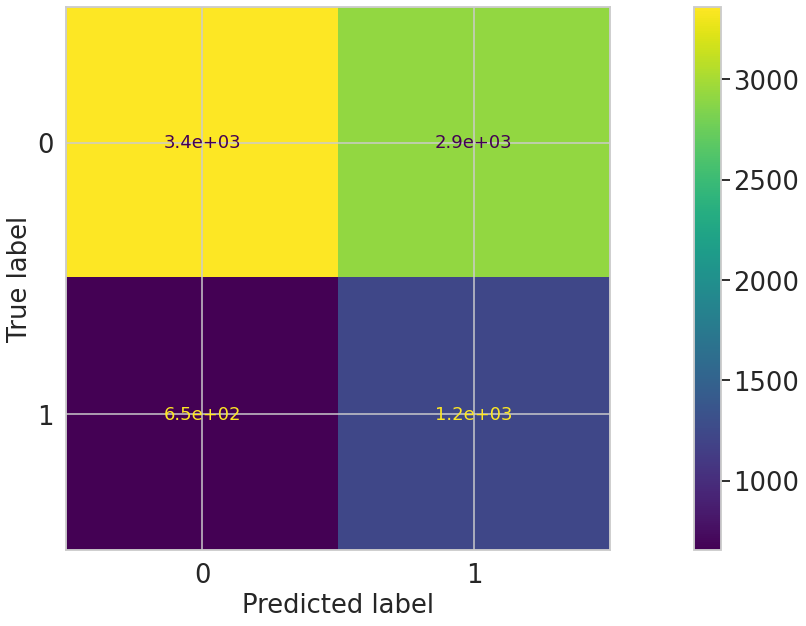

Accuracy:  0.5634940053829215
F1 Score:  0.41141537446387333
Roc Auc Score:  0.5980892377337645


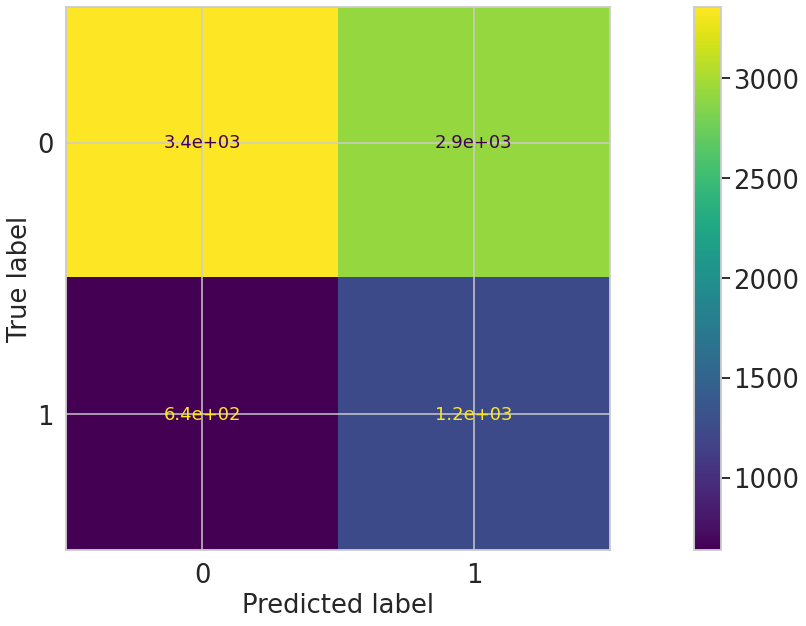

Accuracy:  0.5628288266242506
F1 Score:  0.4189299073020003
Roc Auc Score:  0.605282474689866


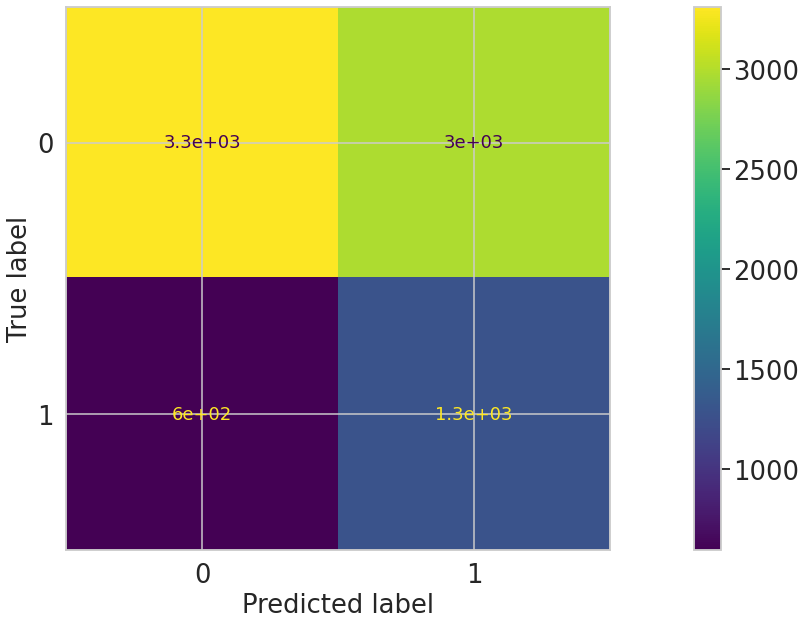

==Summary==
Accuracy: 0.5627013632177892 mean 0.0007050112965550258 std
F1Score: 0.41249841070448023 mean 0.004869741409009034 std
Roc_Auc: 0.5990181453288197 mean 0.004780914036905157 std


Accuracy:  0.5786325948076662
F1 Score:  0.42077727952167415
Roc Auc Score:  0.6113347422039692


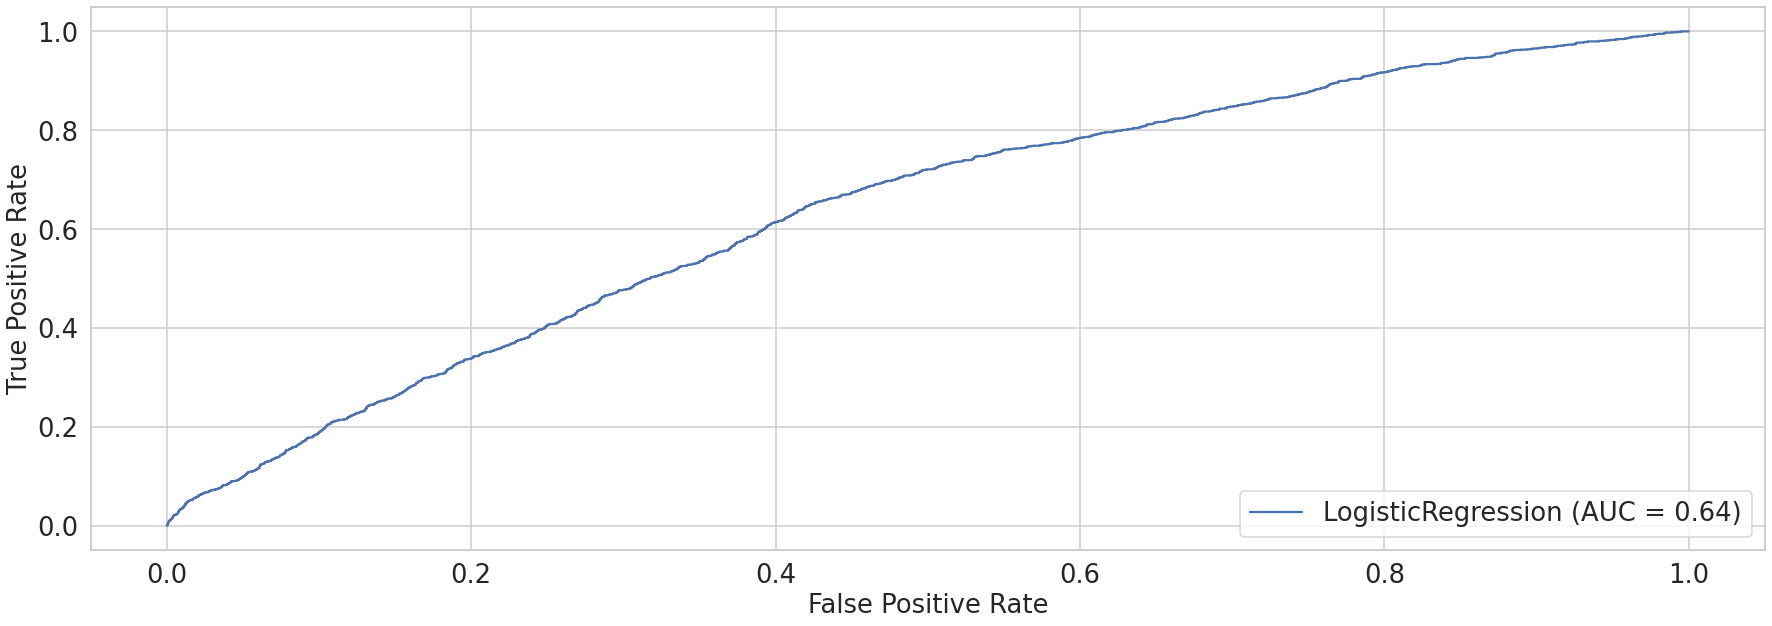

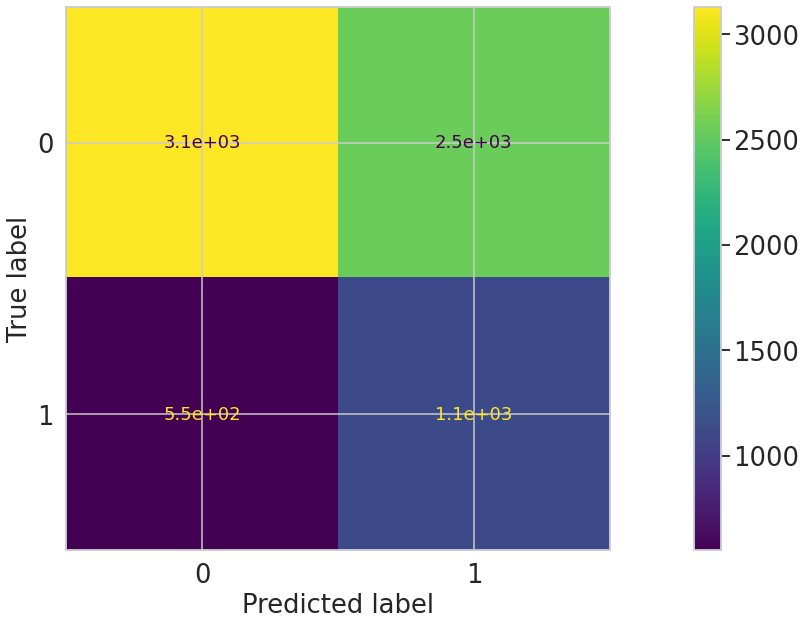

In [82]:
# Почему байас?
# Логистическая регрессия очень слабо реагировала на отклики и плохо обучалась
# Деревья и бустинг давали низкие показатели accuracy и давали предпочтение 0 классу
# По признакам среди всех алгоритмов отбор (отбор по деревьям, RFECV) наилучшим себя показал
# отбор по корреляции с Таргетом и последующий брутфорс оставшихся признаков
# Итоговый топовый скор: 0.50958 :(

def scaled(df, feature):
  if is_integer_dtype(df[feature].dtype):
    return df[feature]
  if len(df[feature].unique()) > 2:
    return scaler.fit_transform(df[feature].values.reshape(-1, 1))
  return df[feature]

clf = GaussianNB()

# Uncomment for cross-validation
cv = StratifiedKFold(n_splits=3)

prev_best_auc = None
max_features = 12
# По сути обычный bruteforce на оставшихся фичах
# Критерии остановки: достигнуто максимальное кол-во фичей или новые фичи не улучшают модель
while len(X.columns) < max_features:
  best_auc = None
  feature_to_add = None
  for dffeature in df.columns.drop('TARGET'):
    # Скипаем фичи, которые уже есть в датасете
    if dffeature in X.columns:
      continue
    # accs = []
    # f1 = []
    roc_auc = []
    # Кросс-валидация датасета
    X[dffeature] = scaled(df, dffeature)
    for i, (train, test) in enumerate(cv.split(X, y)):
      X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
      for feature in X.columns:
        if is_integer_dtype(X[feature].dtype):
          X_train[feature].fillna(X_train[feature].median(), inplace=True)
          X_test[feature].fillna(X_test[feature].median(), inplace=True)
        else:
          X_train[feature].fillna(X_train[feature].mean(), inplace=True)
          X_test[feature].fillna(X_test[feature].mean(), inplace=True)
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      # accs.append(accuracy_score(y_test, y_pred))
      # f1.append(f1_score(y_test, y_pred))
      roc_auc.append(roc_auc_score(y_test, y_pred))
    mean_auc = np.mean(roc_auc)
    if best_auc is None or best_auc < mean_auc:
      feature_to_add = dffeature
      best_auc = mean_auc
    X = X.drop(dffeature, axis=1)
  print(prev_best_auc, best_auc)
  if prev_best_auc is None or prev_best_auc < best_auc:
    X[feature_to_add] = scaled(df, feature_to_add)
    prev_best_auc = best_auc
    print('add {}, columns {}'.format(feature_to_add, len(X.columns)))
  else:
    break
  # print('Accuracy: ', accuracy_score(y_test, y_pred))
  # print('F1 Score: ', f1_score(y_test, y_pred))
  # print('Roc Auc Score: ', roc_auc_score(y_test, y_pred))
  # plot_confusion_matrix(clf, X_test, y_test) 
  # plt.show()

# print('==Summary==')
# print('Accuracy: {} mean {} std'.format(np.mean(accs), np.std(accs)))
# print('F1Score: {} mean {} std'.format(np.mean(f1), np.std(f1)))
# print('Roc_Auc: {} mean {} std'.format(np.mean(roc_auc), np.std(roc_auc)))
# print('===========\n\n')

# Обучаем на полной выборке
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
for feature in X.columns:
  if is_integer_dtype(X[feature].dtype):
    X_train[feature].fillna(X_train[feature].median(), inplace=True)
    X_test[feature].fillna(X_test[feature].median(), inplace=True)
    df_test[feature].fillna(df_test[feature].median(), inplace=True)
  else:
    X_train[feature].fillna(X_train[feature].mean(), inplace=True)
    X_test[feature].fillna(X_test[feature].mean(), inplace=True)
    df_test[feature].fillna(df_test[feature].mean(), inplace=True)

# Uncomment for RFECV selector
# Будет работать противоположно нашему брутфорсу, удаляя фичи из датасета
# selector = RFECV(clf, step=1, cv=4, scoring='roc_auc')
# selector.fit(X_train, y_train)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('Roc Auc Score: ', roc_auc_score(y_test, y_pred))
plot_roc_curve(clf, X_test, y_test)
plot_confusion_matrix(clf, X_test, y_test) 
plt.show()

In [83]:
len(X.columns)

8

In [84]:
# Скейлимся в тесте тоже
df_test_clean = df_test[X.columns]
scaler = StandardScaler()

for f in df_test_clean.columns:
  if is_integer_dtype(df_test_clean[f].dtype):
    continue
  if len(df_test_clean[f].unique()) > 2:
    df_test_clean[f] = scaler.fit_transform(df_test_clean[f].values.reshape(-1, 1))

pred = clf.predict_proba(df_test_clean)
predictions = clf.predict(df_test_clean)
pred

array([[0.54050355, 0.45949645],
       [0.43319674, 0.56680326],
       [0.74890797, 0.25109203],
       ...,
       [0.68343519, 0.31656481],
       [0.5208135 , 0.4791865 ],
       [0.48428792, 0.51571208]])

In [85]:
print(len(predictions[predictions == 1]))

5230


In [86]:
data = {'ID': df_test['ID'].to_numpy(), 'TARGET': pred[:, 1]}
final = pd.DataFrame(data=data)
final.to_csv(path_or_buf='/content/data/out.csv', index=False)